In [1]:
# standard python modules
%matplotlib inline
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import statsmodels.api as sm


# my modules
import src.env as env
import src.wrangle as wr
import src.evaluate as evaluate 

# setting random seed to 7
np.random.seed(7)

# turning off red warnings
import warnings
warnings.filterwarnings("ignore")

# module for fixing imported modules
from importlib import reload

In [2]:
df = wr.zillow_2017()

In [3]:
df['sq_feet_2'] = df['sq_feet']*df['sq_feet']

In [4]:
df2.head()

NameError: name 'df2' is not defined

### Some Exploration

In [411]:
list(df.columns)

['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips']

In [664]:
def fips_viz(df):
    plt.figure(figsize=(20,20))
    big_variables= ['tax_value','sq_feet']
    small_variables= ['bedrooms','baths']

    n =220
    for i in big_variables:
        n+=1 
        plt.subplot(n)
        sns.histplot(data = df, x=i, hue='fips', kde = True, bins= 50, palette='hsv_r')

    for i in small_variables:
        n+=1 
        plt.subplot(n)
        sns.histplot(data = df, x=i, hue='fips', bins = 4, palette='hsv')    


    plt.show()

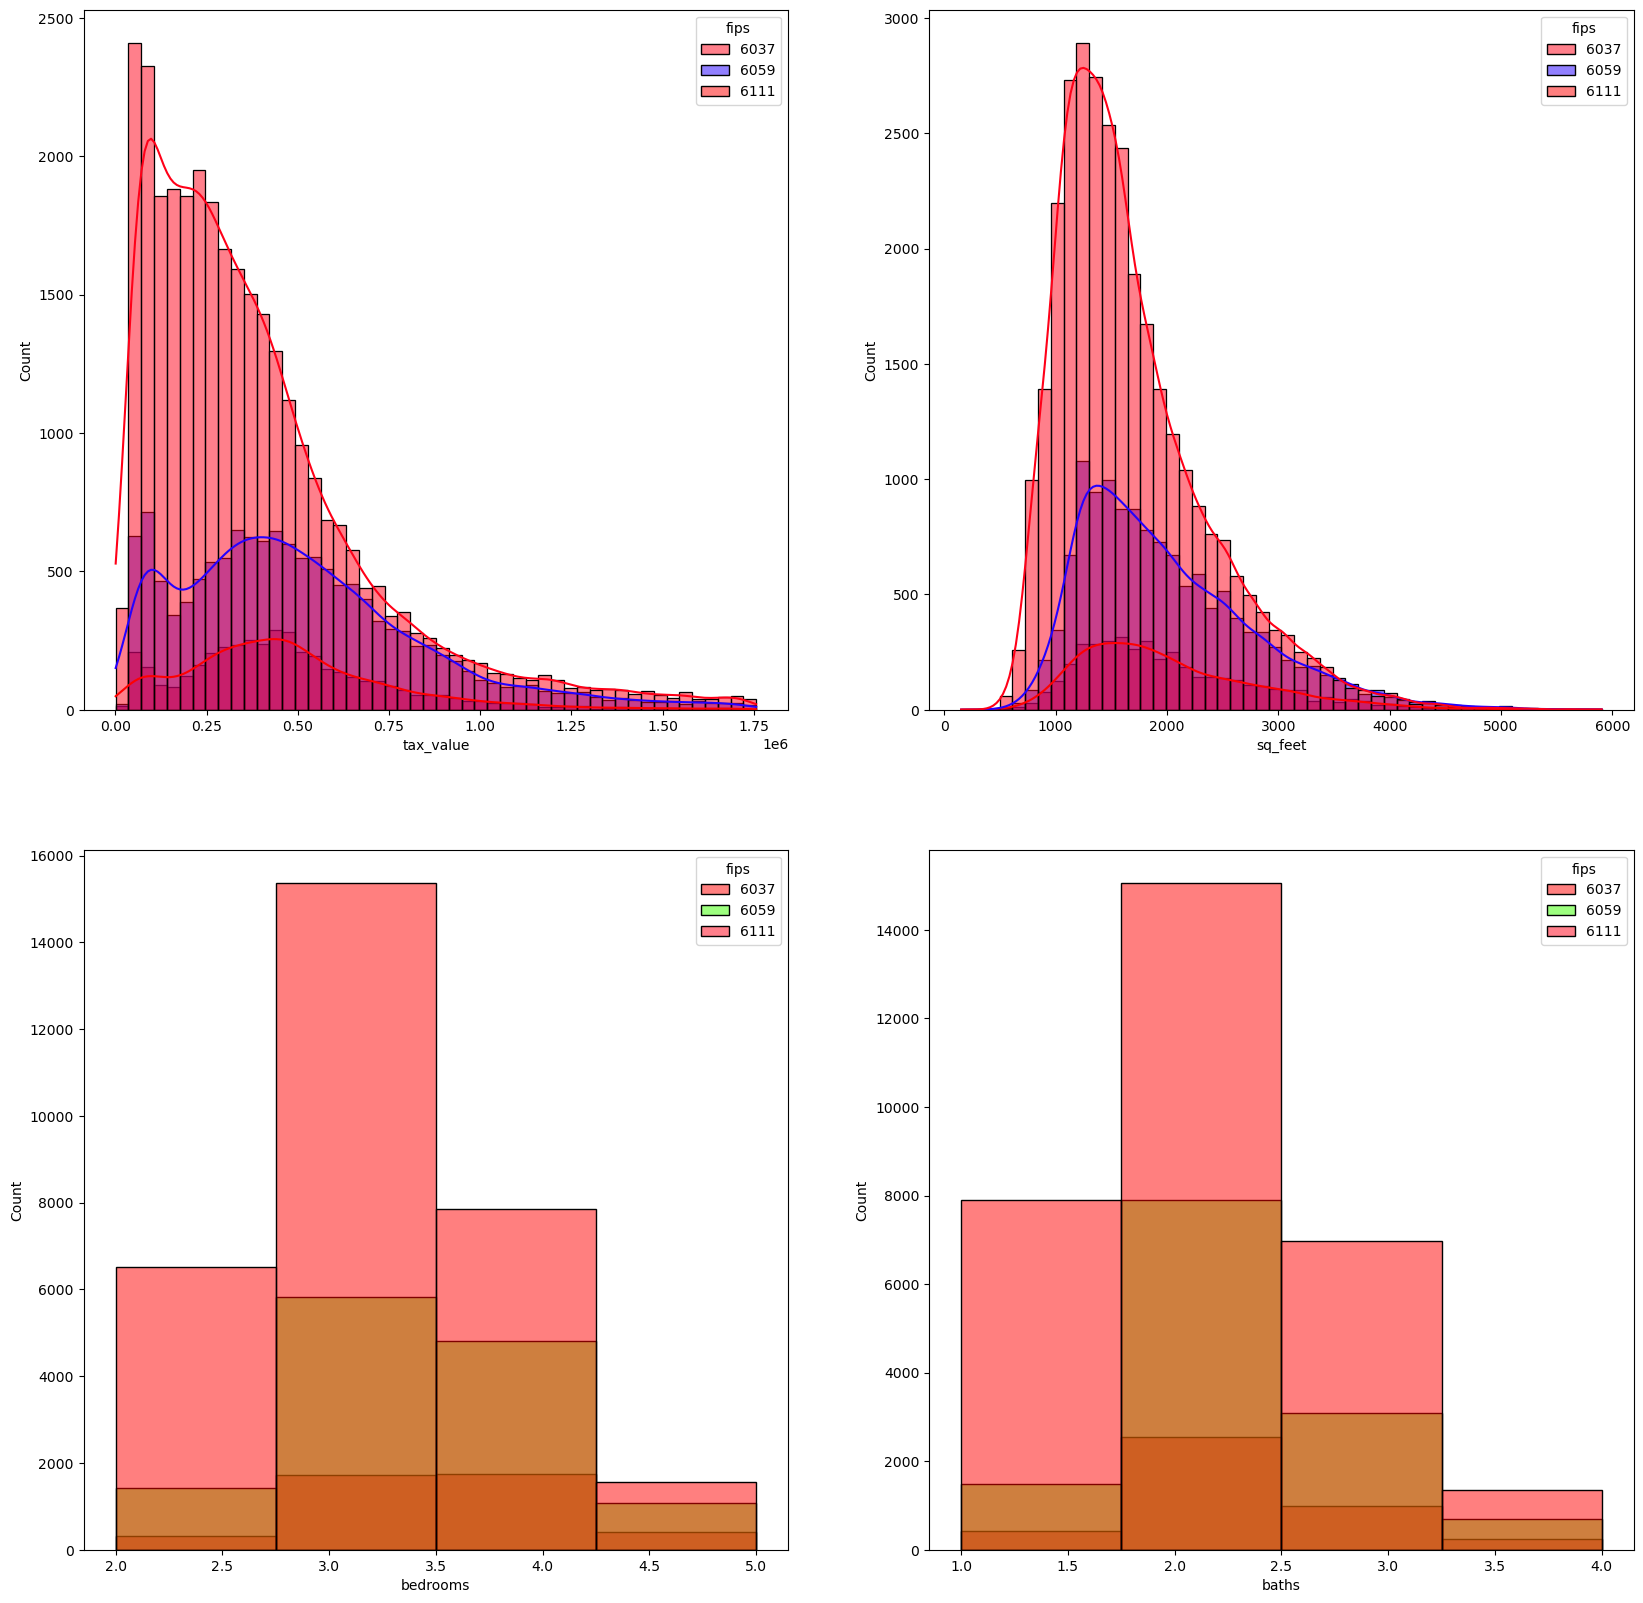

In [665]:
fips_viz(df)

[]

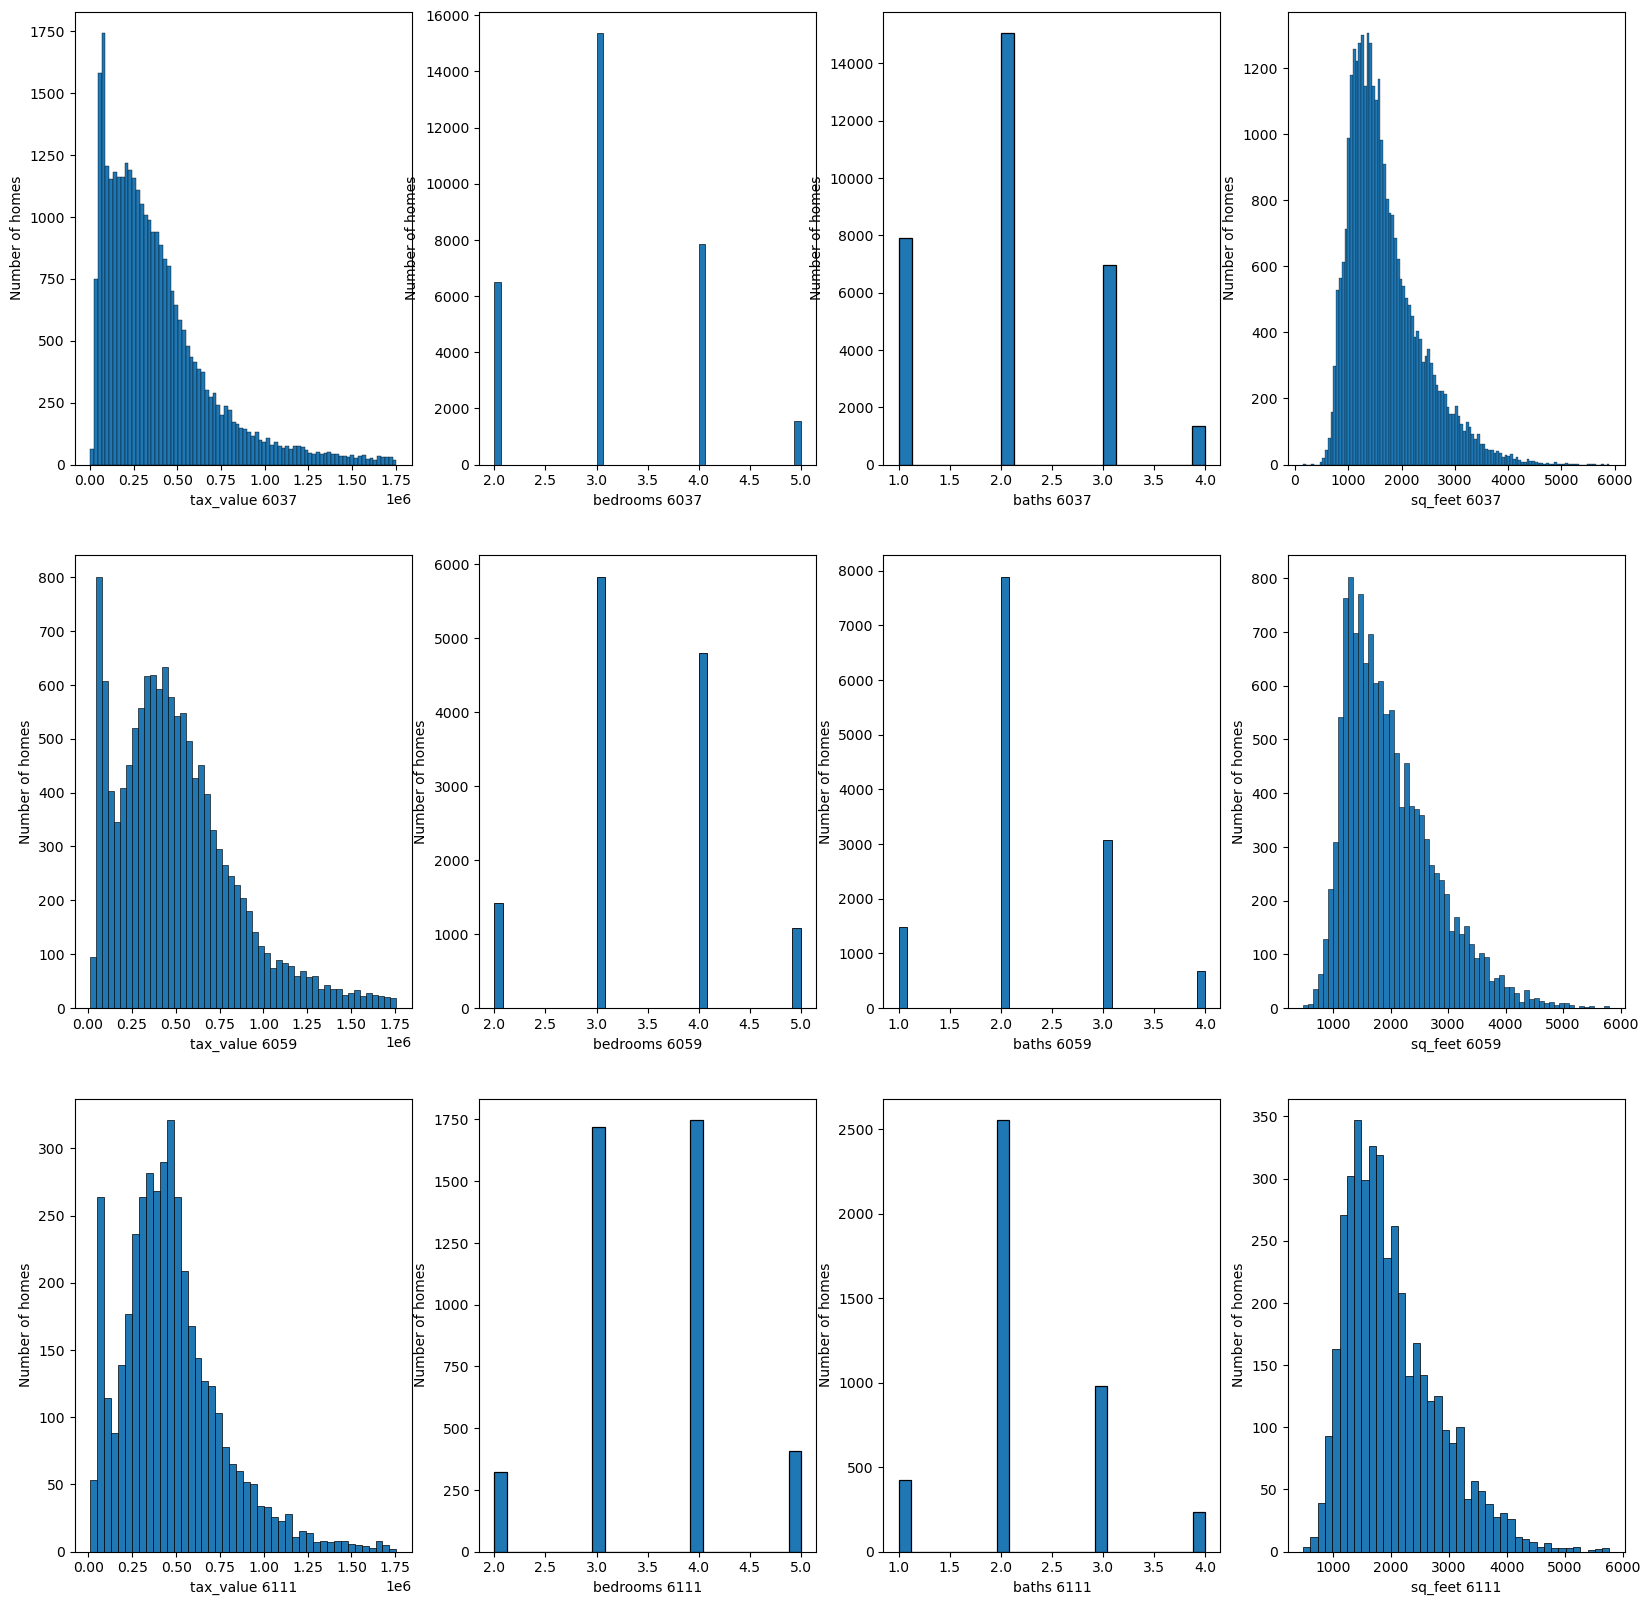

In [466]:
plt.figure(figsize = (20,20))

counties = (6037, 6059, 6111)
item = df['fips'] == 6037
variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']
booled_df = df[variables][item]

n = 1

for k in counties:
    item = df['fips'] == k
    booled_df = df[variables][item]
    
    
    for i in variables:

        plt.subplot(3,4,n)
        sns.histplot(data = booled_df, x=i, alpha=1)
        plt.xlabel(f'{i} {k}')
        plt.ylabel('Number of homes')
        n+=1 

    
#plt.subplots_adjust(hspace=0.5)
plt.plot()

### Fip / County information

- 6037 = Los Angeles County
- 6059 = Orange County 
- 6111 = Ventura County

### Separating Data into useful data frames

In [575]:
df.columns

Index(['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips', 'sq_feet_2'], dtype='object')

In [576]:
'''
Separating our big dataset by using boolean masks to identify our different counties

'''

keeper_variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet', 'sq_feet_2']

county = df['fips'] == 6037
la_df = df[keeper_variables][county]

county = df['fips'] == 6059
orange_df = df[keeper_variables][county]

county = df['fips'] == 6111
ventura_df = df[keeper_variables][county]

In [571]:
(la_df.shape[0], orange_df.shape[0], ventura_df.shape[0], 
 la_df.shape[0]+ orange_df.shape[0]+ ventura_df.shape[0], df.shape[0])

(31290, 13143, 4194, 48627, 48627)

In [577]:
'''
Preparing to analyze our simple model as asked for initial evaluatation to be made upon
separating our data frames into train, validate and test data frames
further separates our data into our indepdendent and dependent variables
'''

# split data without differentiating counties
x_train, y_train, x_validate, y_validate, x_test, y_test = wr.x_y(df, 'tax_value')

# split la county dfs
la_x_train, la_y_train, la_x_validate, la_y_validate, la_x_test, la_y_test = wr.x_y(la_df, 'tax_value')

#split orange county dfs
or_x_train, or_y_train, or_x_validate, or_y_validate, or_x_test, or_y_test = wr.x_y(orange_df, 'tax_value')

# split ventura county dfs
vent_x_train, vent_y_train, vent_x_validate, vent_y_validate, vent_x_test, vent_y_test = wr.x_y(ventura_df, 'tax_value')

In [574]:
x_train

,bedrooms,baths,sq_feet,fips
3222,3,2,1613,6037
31101,4,2,2084,6059
8113,4,4,2775,6059
31779,4,2,1605,6059
12232,4,3,2649,6037
...,...,...,...,...
42103,3,2,1800,6059
1780,4,2,1867,6037
46812,3,2,1436,6037
27413,4,2,2115,6111


In [497]:
(la_y_test.shape[0],or_y_test.shape[0],vent_y_test.shape[0], 
la_y_test.shape[0]+or_y_test.shape[0]+vent_y_test.shape[0], y_test.shape[0])

(6192, 2625, 837, 9654, 9728)

### Creating results data frame for baseline, simple model and filling it

In [506]:
# creating dataframe to hold values for comparison between prediction models
predictions = pd.DataFrame()

# target column is the variable we are trying to predict with machine learning
predictions['target'] = y_train

# produce baseline predictions based on the mean of the tax values and median values
predictions['baseline_mean'] = round(y_train.mean(),3)
predictions['baseline_median'] = y_train.median()


In [562]:
def do_regression():

    # creating dataframe to hold values for comparison between prediction models
    predictions = pd.DataFrame()

    # creating simple regression model BEFORE splitting by county

    # make the model
    lm = LinearRegression()

    # fit data to simple regression
    lm.fit(x_train, y_train)

    # make predictions
    predictions['simple_model'] = lm.predict(x_train)

In [670]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27236 entries, 33964 to 45430
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   target           27236 non-null  int64  
 1   baseline_mean    27236 non-null  float64
 2   baseline_median  27236 non-null  float64
 3   simple_model1    27236 non-null  float64
 4   simple_model2    27236 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


In [18]:
# reordering columns in predictions dataframe
#predictions = predictions.iloc[:,[1,2,3]]

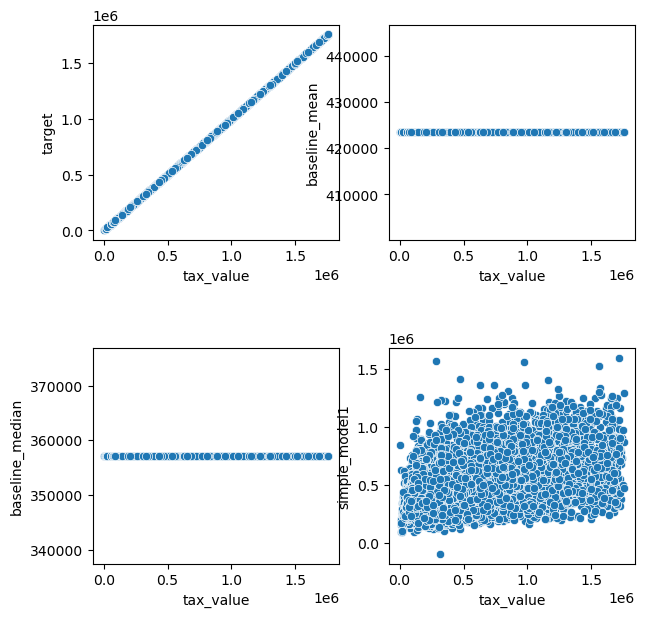

In [510]:
plt.figure(figsize=(7,7))
n = 221
for i in predictions.columns:
    
    plt.subplot(n)
    evaluate.plot_residuals(y_train,predictions[i])
    n+=1
    #plt.show()
plt.subplots_adjust(hspace=.5)    
plt.show()




In [511]:
def measure_performance(df):
    df = pd.DataFrame()
    for i in df.columns:
        df = df.append(evaluate.regression_errors(df['target'], df[i], df=True, features=4), ignore_index=True)
        #test_test['Model'] = predictions.columns[i]
        #test_test.set_index(predictions.columns[i], inplace=True)


    df['Model'] = np.array(df.columns)
    df.set_index('Model', inplace=True)
    return df



In [578]:
''' 
making models for each county
'''

# la county
# fit data to simple regression
lm.fit(la_x_train, la_y_train)

# make predictions
la_simple_model = lm.predict(la_x_train)

# orange county
# fit data to simple regression
lm.fit(or_x_train, or_y_train)

# make predictions
or_simple_model = lm.predict(or_x_train)

# la county
# fit data to simple regression
lm.fit(vent_x_train, vent_y_train)

# make predictions
vent_simple_model = lm.predict(vent_x_train)

In [672]:
'''
running the initial set of models through the function which will create our initial dataframe
holding performance measures for each model
'''
comparison_df = measure_performance(predictions)

In [669]:
predictions.head()

,target,baseline_mean,baseline_median,simple_model1,simple_model2
33964,196792,423409.659,357196.5,328371.122985,226534.456458
13827,87770,423409.659,357196.5,386188.806980,704337.342298
2596,199612,423409.659,357196.5,459903.409159,561213.950201
43645,96043,423409.659,357196.5,398186.727245,499451.079956
32954,132994,423409.659,357196.5,419104.143237,394166.421630


In [673]:
comparison_df

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,2.772934e+15,0.000000e+00,2.772934e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,2.000000e-03,2.772934e+15,2.772934e+15,1.018114e+11,319078.930,0.000,-0.000
baseline_median,1.194076e+14,2.892342e+15,3.011749e+15,1.061955e+11,325876.581,-0.043,-0.043
simple_model1,8.251612e+14,1.947773e+15,2.772934e+15,7.151465e+10,267422.239,0.298,0.297
simple_model2,8.170598e+14,3.594652e+15,4.411711e+15,1.319816e+11,363292.755,-0.296,-0.297


In [579]:
''' 
appending to the performance measure recording dataframe, our new models' performance
'''
comparison_df = comparison_df.append(evaluate.regression_errors(la_y_train, la_simple_model, df=True, features = 5), ignore_index=True)
comparison_df = comparison_df.append(evaluate.regression_errors(or_y_train, or_simple_model, df=True, features = 5), ignore_index=True)
comparison_df = comparison_df.append(evaluate.regression_errors(vent_y_train, vent_simple_model, df=True, features = 5), ignore_index=True)

In [564]:
comparison_df = comparison_df.append(evaluate.regression_errors(y_train, predictions['simple_model2'], df=True, features = 5), ignore_index=True)

In [580]:
'''
replacing the index with the name of the models in our performance measure recording dataframe
'''

model_list = ['target', 'baseline_mean', 'baseline_median', 
              'simple_model', 'la_simple_model', 'or_simple_model', 'vent_simple_model', 'simple_model_sq_root2',
             'la_simple_model_sq_root2', 'or_simple_model_sq_root2', 'vent_simple_model_sq_root2']

comparison_df['Model'] = model_list
comparison_df.set_index('Model', inplace=True)

In [581]:
comparison_df

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,2.772934e+15,0.000000e+00,2.772934e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,2.000000e-03,2.772934e+15,2.772934e+15,1.018114e+11,319078.930,0.000,-0.000
baseline_median,1.194076e+14,2.892342e+15,3.011749e+15,1.061955e+11,325876.581,-0.043,-0.043
simple_model,8.251612e+14,1.947773e+15,2.772934e+15,7.151465e+10,267422.239,0.298,0.297
la_simple_model,3.296570e+14,1.317618e+15,1.647275e+15,7.600034e+10,275681.588,0.200,0.200
or_simple_model,3.161336e+14,4.862864e+14,8.024200e+14,6.616141e+10,257218.607,0.394,0.394
vent_simple_model,8.616741e+13,9.620753e+13,1.823749e+14,4.107922e+10,202680.086,0.472,0.472
simple_model_sq_root2,8.169241e+14,1.923003e+15,2.739927e+15,7.060517e+10,265716.340,0.298,0.298
la_simple_model_sq_root2,3.515468e+14,1.348088e+15,1.699634e+15,7.693686e+10,277374.940,0.207,0.207


### Those models performed pretty poorly. Baseline is terrible, regardless of it being the mean version or median version. The simple model worked better but was similarly awful. 

- time to work on tossing more outliers

In [293]:
df.columns

Index(['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips'], dtype='object')

In [ ]:
# This boolean mask did not work out
df[df['tax_value'] <= (df['tax_value'].max()*.02)]

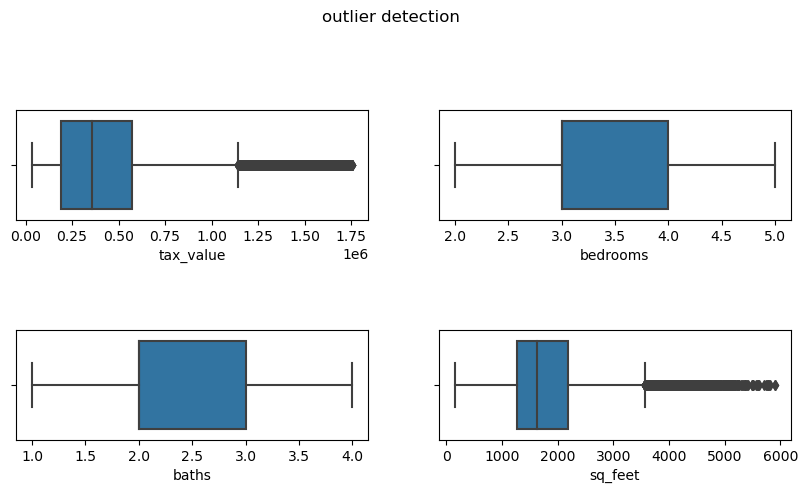

In [505]:
plt.figure(figsize=(10,10))
variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']
n=1
for i in variables:
    #n = 1
    plt.subplot(4,2,n)
    sns.boxplot(x = df[i])
    n +=1
    
plt.subplots_adjust(hspace=1)   
plt.suptitle('outlier detection')
plt.show()

# Messing with boolean masks to better handle outlier observations

In [519]:
df.shape[0]

48269

In [123]:
(df['tax_value'].max())*.88

1757580.8800000001

In [127]:
df[bool2].count()/(df.count())*100

tax_value    0.83701
bedrooms     0.83701
baths        0.83701
sq_feet      0.83701
fips         0.83701
dtype: float64

In [148]:
df[df.baths <= 4].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [149]:
bathroom_bool = df['baths'] <= 4
df[bool2].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [150]:
high_bed_bool = df['bedrooms'] <= 5 
low_bed_bool  = df['bedrooms'] > 1
tax_bool = df['tax_value'] < 1757580
bathroom_bool = df['baths'] <= 4

In [611]:
df2.columns

Index(['tax_value', 'bedrooms', 'baths', 'fips', 'sq_feet_2'], dtype='object')

In [607]:
df2.drop(columns = "sq_feet", inplace = True)

"\n# DataFrame 2 - square feet dropped\n# creates a vertical heat map, correlating values in dataframe with a feature in the dataframe \n# (the target value to be predicted)\nplt.subplot(1,2,2)\nheatmap = sns.heatmap(df2.corr()[['tax_value']].sort_values(by='tax_value', ascending = False), vmin=-1, vmax=1, annot=True,cmap='BrBG')\n\n# title information\nheatmap.set_title('DF 2 \nFeatures Correlating with \nTax Value', fontdict={'fontsize':18}, pad=16);\n\nplt.show()\n"

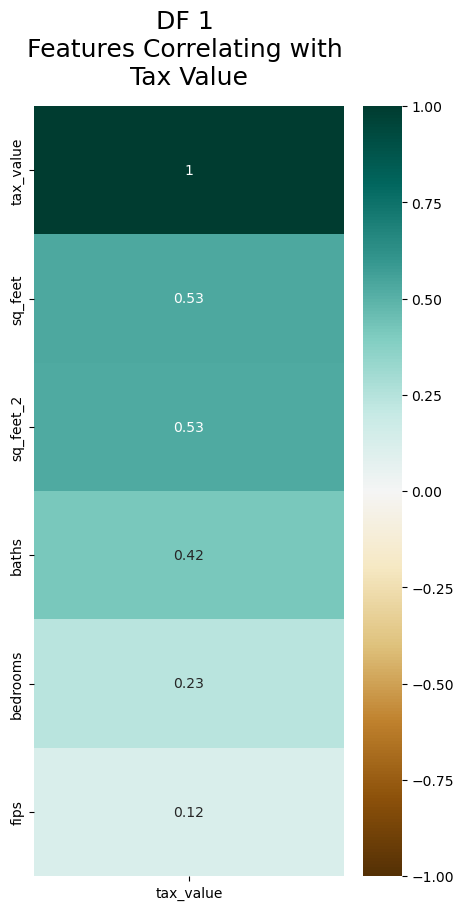

In [643]:
''' creating correlation heat maps for our model with square feet - squared and the one with squared square feet having dropped square feet
The first df has both square feet and squared, square feet features
The second df has only the squared square feet feature
'''

# sets size of the vizualization product
plt.figure(figsize=(5,10))

# DataFrame 1 - both features
# creates a vertical heat map, correlating values in dataframe with a feature in the dataframe 
# (the target value to be predicted)
#plt.subplot(1,2,1)
heatmap = sns.heatmap(df.corr()[['tax_value']].sort_values(by='tax_value', ascending = False), vmin=-1, vmax=1, annot=True,cmap='BrBG')

# title information
heatmap.set_title('DF 1 \nFeatures Correlating with \nTax Value', fontdict={'fontsize':18}, pad=16);

'''
# DataFrame 2 - square feet dropped
# creates a vertical heat map, correlating values in dataframe with a feature in the dataframe 
# (the target value to be predicted)
plt.subplot(1,2,2)
heatmap = sns.heatmap(df2.corr()[['tax_value']].sort_values(by='tax_value', ascending = False), vmin=-1, vmax=1, annot=True,cmap='BrBG')

# title information
heatmap.set_title('DF 2 \nFeatures Correlating with \nTax Value', fontdict={'fontsize':18}, pad=16);

plt.show()
'''

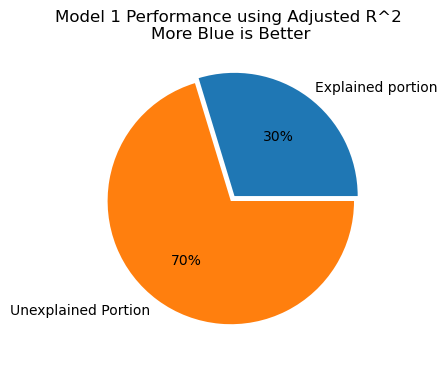

In [ ]:
'''
Pie chart for Model 1
'''

labels = ['Explained portion', 'Unexplained Portion']
values = [comparison_df['AdjR^2']['simple_model'],(1-comparison_df['AdjR^2']['simple_model'])]
explode = [0.05, 0]
palette_color = sns.color_palette('tab10')

#setting title information
plt.title('Model 1 Performance using Adjusted R^2 \nMore Blue is Better')

#creating pie with variables set above
plt.pie(values, labels=labels, colors = palette_color, explode = explode, autopct='%.0f%%')

plt.show()

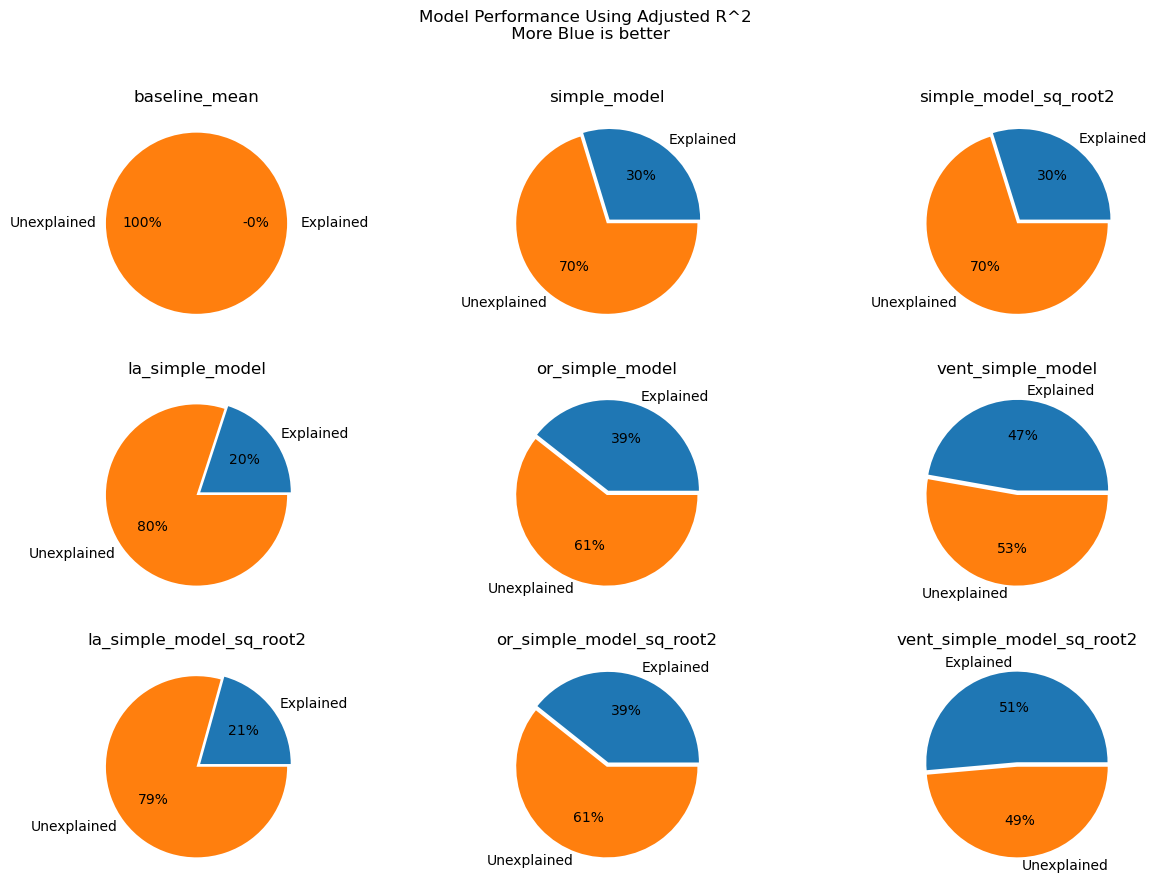

In [641]:
'''
Pie charts for County Specific Models
'''
plt.figure(figsize=(15,10))

models = ['baseline_mean', 'simple_model', 'simple_model_sq_root2', 
     'la_simple_model', 'or_simple_model', 'vent_simple_model',
     'la_simple_model_sq_root2', 'or_simple_model_sq_root2', 'vent_simple_model_sq_root2']
labels = ['Explained', 'Unexplained']
n=1
for i in models:
    plt.subplot(3,3,n)
    values = [comparison_df['AdjR^2'][i],(1-comparison_df['AdjR^2'][i])]
    explode = [0.05, 0]
    palette_color = sns.color_palette('tab10')

    #setting title information
    plt.title(f'{i}')

    #creating pie with variables set above
    plt.pie(values, labels=labels, colors = palette_color, explode = explode, autopct='%.0f%%')
    n+=1
    
plt.suptitle('Model Performance Using Adjusted R^2 \n More Blue is better')
plt.show()